<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[03:04:19] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


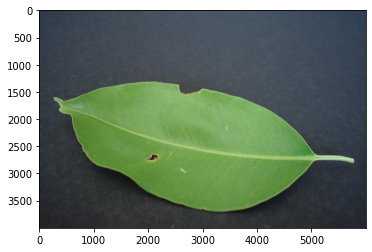

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

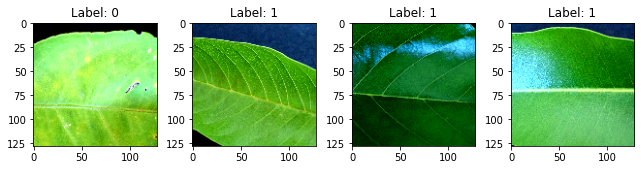

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[03:04:27] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[03:04:29] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2573341800888254 samples/sec                   batch loss = 0.8128144145011902 | accuracy = 0.55


Epoch[1] Batch[10] Speed: 1.2651204148835726 samples/sec                   batch loss = 0.3383444547653198 | accuracy = 0.525


Epoch[1] Batch[15] Speed: 1.265827143671455 samples/sec                   batch loss = 0.3640116751194 | accuracy = 0.6166666666666667


Epoch[1] Batch[20] Speed: 1.267343390266487 samples/sec                   batch loss = 0.7736595869064331 | accuracy = 0.6


Epoch[1] Batch[25] Speed: 1.2633674102544021 samples/sec                   batch loss = 0.3384064733982086 | accuracy = 0.6


Epoch[1] Batch[30] Speed: 1.2650852136312856 samples/sec                   batch loss = 0.4660629332065582 | accuracy = 0.6


Epoch[1] Batch[35] Speed: 1.2617050268337298 samples/sec                   batch loss = 0.32299724221229553 | accuracy = 0.6428571428571429


Epoch[1] Batch[40] Speed: 1.2606935145266063 samples/sec                   batch loss = 0.581415057182312 | accuracy = 0.61875


Epoch[1] Batch[45] Speed: 1.2622747814258322 samples/sec                   batch loss = 1.0697282552719116 | accuracy = 0.6222222222222222


Epoch[1] Batch[50] Speed: 1.264385506531846 samples/sec                   batch loss = 0.3211934566497803 | accuracy = 0.635


Epoch[1] Batch[55] Speed: 1.263877729144478 samples/sec                   batch loss = 1.0706474781036377 | accuracy = 0.6454545454545455


Epoch[1] Batch[60] Speed: 1.266476246006503 samples/sec                   batch loss = 0.5241394639015198 | accuracy = 0.6375


Epoch[1] Batch[65] Speed: 1.2651273790490605 samples/sec                   batch loss = 0.7399942874908447 | accuracy = 0.6384615384615384


Epoch[1] Batch[70] Speed: 1.2589199675778067 samples/sec                   batch loss = 0.4896533489227295 | accuracy = 0.6464285714285715


Epoch[1] Batch[75] Speed: 1.2625408493719434 samples/sec                   batch loss = 1.5290429592132568 | accuracy = 0.6466666666666666


Epoch[1] Batch[80] Speed: 1.2645724896275412 samples/sec                   batch loss = 1.0972645282745361 | accuracy = 0.6375


Epoch[1] Batch[85] Speed: 1.261032937813394 samples/sec                   batch loss = 0.30540674924850464 | accuracy = 0.638235294117647


Epoch[1] Batch[90] Speed: 1.263983899085102 samples/sec                   batch loss = 0.5712173581123352 | accuracy = 0.6361111111111111


Epoch[1] Batch[95] Speed: 1.2663917380721654 samples/sec                   batch loss = 0.678046464920044 | accuracy = 0.6368421052631579


Epoch[1] Batch[100] Speed: 1.261672861771406 samples/sec                   batch loss = 0.9446155428886414 | accuracy = 0.6325


Epoch[1] Batch[105] Speed: 1.2630825457519919 samples/sec                   batch loss = 0.8902397751808167 | accuracy = 0.638095238095238


Epoch[1] Batch[110] Speed: 1.265482462277198 samples/sec                   batch loss = 0.3291608691215515 | accuracy = 0.6454545454545455


Epoch[1] Batch[115] Speed: 1.2635314439575251 samples/sec                   batch loss = 0.5582388639450073 | accuracy = 0.6521739130434783


Epoch[1] Batch[120] Speed: 1.2627580804337262 samples/sec                   batch loss = 1.1287864446640015 | accuracy = 0.6541666666666667


Epoch[1] Batch[125] Speed: 1.271425598574797 samples/sec                   batch loss = 0.512767493724823 | accuracy = 0.654


Epoch[1] Batch[130] Speed: 1.266015699841405 samples/sec                   batch loss = 0.821631133556366 | accuracy = 0.6557692307692308


Epoch[1] Batch[135] Speed: 1.2610472502916938 samples/sec                   batch loss = 1.1343069076538086 | accuracy = 0.6592592592592592


Epoch[1] Batch[140] Speed: 1.264400276375335 samples/sec                   batch loss = 0.3771704137325287 | accuracy = 0.6589285714285714


Epoch[1] Batch[145] Speed: 1.2683421136626136 samples/sec                   batch loss = 1.1357218027114868 | accuracy = 0.6620689655172414


Epoch[1] Batch[150] Speed: 1.262103288324638 samples/sec                   batch loss = 0.4436974823474884 | accuracy = 0.665


Epoch[1] Batch[155] Speed: 1.2599259854642895 samples/sec                   batch loss = 0.40870314836502075 | accuracy = 0.667741935483871


Epoch[1] Batch[160] Speed: 1.265166494279865 samples/sec                   batch loss = 0.32381653785705566 | accuracy = 0.6640625


Epoch[1] Batch[165] Speed: 1.262585980908007 samples/sec                   batch loss = 0.4687369465827942 | accuracy = 0.6666666666666666


Epoch[1] Batch[170] Speed: 1.2632324283860643 samples/sec                   batch loss = 1.4878756999969482 | accuracy = 0.6661764705882353


Epoch[1] Batch[175] Speed: 1.2660268774264511 samples/sec                   batch loss = 0.798302948474884 | accuracy = 0.6628571428571428


Epoch[1] Batch[180] Speed: 1.2608694573882038 samples/sec                   batch loss = 0.36468619108200073 | accuracy = 0.6611111111111111


Epoch[1] Batch[185] Speed: 1.261895014424319 samples/sec                   batch loss = 0.4252096116542816 | accuracy = 0.6662162162162162


Epoch[1] Batch[190] Speed: 1.2585943324449693 samples/sec                   batch loss = 0.6326497197151184 | accuracy = 0.6684210526315789


Epoch[1] Batch[195] Speed: 1.2620765145381414 samples/sec                   batch loss = 1.1971629858016968 | accuracy = 0.6679487179487179


Epoch[1] Batch[200] Speed: 1.2637774791982586 samples/sec                   batch loss = 0.5077870488166809 | accuracy = 0.6675


Epoch[1] Batch[205] Speed: 1.2602404769577344 samples/sec                   batch loss = 0.693749189376831 | accuracy = 0.6719512195121952


Epoch[1] Batch[210] Speed: 1.2652091421778284 samples/sec                   batch loss = 0.8521638512611389 | accuracy = 0.669047619047619


Epoch[1] Batch[215] Speed: 1.2657060541342835 samples/sec                   batch loss = 0.3572589159011841 | accuracy = 0.6709302325581395


Epoch[1] Batch[220] Speed: 1.260506256131243 samples/sec                   batch loss = 1.0338544845581055 | accuracy = 0.6715909090909091


Epoch[1] Batch[225] Speed: 1.2643863641262252 samples/sec                   batch loss = 0.9191824197769165 | accuracy = 0.6722222222222223


Epoch[1] Batch[230] Speed: 1.2635288746558893 samples/sec                   batch loss = 0.10492843389511108 | accuracy = 0.6739130434782609


Epoch[1] Batch[235] Speed: 1.2654609855790444 samples/sec                   batch loss = 0.9833856821060181 | accuracy = 0.6712765957446809


Epoch[1] Batch[240] Speed: 1.265825806594236 samples/sec                   batch loss = 0.543439507484436 | accuracy = 0.6729166666666667


Epoch[1] Batch[245] Speed: 1.2594980825501516 samples/sec                   batch loss = 0.6324677467346191 | accuracy = 0.6724489795918367


Epoch[1] Batch[250] Speed: 1.2642154399732586 samples/sec                   batch loss = 0.6069262623786926 | accuracy = 0.674


Epoch[1] Batch[255] Speed: 1.2653071382857235 samples/sec                   batch loss = 0.3972114026546478 | accuracy = 0.6735294117647059


Epoch[1] Batch[260] Speed: 1.2597818053266077 samples/sec                   batch loss = 0.31615617871284485 | accuracy = 0.6759615384615385


Epoch[1] Batch[265] Speed: 1.2577185607392953 samples/sec                   batch loss = 0.36658763885498047 | accuracy = 0.6745283018867925


Epoch[1] Batch[270] Speed: 1.2609121951344162 samples/sec                   batch loss = 1.0367454290390015 | accuracy = 0.6768518518518518


Epoch[1] Batch[275] Speed: 1.26662091076096 samples/sec                   batch loss = 1.0400004386901855 | accuracy = 0.6745454545454546


Epoch[1] Batch[280] Speed: 1.2635559004258168 samples/sec                   batch loss = 0.36436381936073303 | accuracy = 0.6767857142857143


Epoch[1] Batch[285] Speed: 1.2622025131477421 samples/sec                   batch loss = 0.28005868196487427 | accuracy = 0.6754385964912281


Epoch[1] Batch[290] Speed: 1.263219492949305 samples/sec                   batch loss = 0.8500902652740479 | accuracy = 0.6741379310344827


Epoch[1] Batch[295] Speed: 1.2610713263192201 samples/sec                   batch loss = 0.2740994095802307 | accuracy = 0.6754237288135593


Epoch[1] Batch[300] Speed: 1.26211639080434 samples/sec                   batch loss = 0.9317179918289185 | accuracy = 0.675


Epoch[1] Batch[305] Speed: 1.2597060388375203 samples/sec                   batch loss = 0.3245857357978821 | accuracy = 0.6729508196721311


Epoch[1] Batch[310] Speed: 1.2619124786922913 samples/sec                   batch loss = 0.71346116065979 | accuracy = 0.6741935483870968


Epoch[1] Batch[315] Speed: 1.2689252696062767 samples/sec                   batch loss = 0.4317498803138733 | accuracy = 0.6753968253968254


Epoch[1] Batch[320] Speed: 1.2653368168300527 samples/sec                   batch loss = 1.3763163089752197 | accuracy = 0.67578125


Epoch[1] Batch[325] Speed: 1.2658437618668967 samples/sec                   batch loss = 0.7209150195121765 | accuracy = 0.6753846153846154


Epoch[1] Batch[330] Speed: 1.265205421105801 samples/sec                   batch loss = 0.8419513702392578 | accuracy = 0.6742424242424242


Epoch[1] Batch[335] Speed: 1.2657507437896816 samples/sec                   batch loss = 0.5079453587532043 | accuracy = 0.6738805970149254


Epoch[1] Batch[340] Speed: 1.2691226222033916 samples/sec                   batch loss = 0.8123425245285034 | accuracy = 0.6757352941176471


Epoch[1] Batch[345] Speed: 1.2660928005322396 samples/sec                   batch loss = 0.3243027925491333 | accuracy = 0.677536231884058


Epoch[1] Batch[350] Speed: 1.2611363551456174 samples/sec                   batch loss = 0.35767608880996704 | accuracy = 0.6764285714285714


Epoch[1] Batch[355] Speed: 1.2653414929977596 samples/sec                   batch loss = 0.6195982694625854 | accuracy = 0.6753521126760563


Epoch[1] Batch[360] Speed: 1.2617826472185523 samples/sec                   batch loss = 0.4662361145019531 | accuracy = 0.6756944444444445


Epoch[1] Batch[365] Speed: 1.2654875213388455 samples/sec                   batch loss = 0.26574215292930603 | accuracy = 0.6767123287671233


Epoch[1] Batch[370] Speed: 1.27284973708029 samples/sec                   batch loss = 1.8247929811477661 | accuracy = 0.675


Epoch[1] Batch[375] Speed: 1.2600305461659274 samples/sec                   batch loss = 0.4979211091995239 | accuracy = 0.6746666666666666


Epoch[1] Batch[380] Speed: 1.2597975083858393 samples/sec                   batch loss = 0.6314831972122192 | accuracy = 0.675


Epoch[1] Batch[385] Speed: 1.263775765662215 samples/sec                   batch loss = 0.20847293734550476 | accuracy = 0.6753246753246753


Epoch[1] Batch[390] Speed: 1.2667938251448352 samples/sec                   batch loss = 0.7512667775154114 | accuracy = 0.675


Epoch[1] Batch[395] Speed: 1.26423735074362 samples/sec                   batch loss = 0.42193955183029175 | accuracy = 0.6746835443037975


Epoch[1] Batch[400] Speed: 1.2636046258616325 samples/sec                   batch loss = 0.6506351828575134 | accuracy = 0.675


Epoch[1] Batch[405] Speed: 1.263298346159922 samples/sec                   batch loss = 1.0344523191452026 | accuracy = 0.6728395061728395


Epoch[1] Batch[410] Speed: 1.2658857868366926 samples/sec                   batch loss = 0.5182340145111084 | accuracy = 0.6743902439024391


Epoch[1] Batch[415] Speed: 1.2627509522443627 samples/sec                   batch loss = 0.23011726140975952 | accuracy = 0.6759036144578313


Epoch[1] Batch[420] Speed: 1.2578468970297967 samples/sec                   batch loss = 0.5330623388290405 | accuracy = 0.6755952380952381


Epoch[1] Batch[425] Speed: 1.2579231945694287 samples/sec                   batch loss = 0.4209332764148712 | accuracy = 0.6758823529411765


Epoch[1] Batch[430] Speed: 1.259621580823126 samples/sec                   batch loss = 0.46585893630981445 | accuracy = 0.6755813953488372


Epoch[1] Batch[435] Speed: 1.259258814473041 samples/sec                   batch loss = 0.6785051822662354 | accuracy = 0.6775862068965517


Epoch[1] Batch[440] Speed: 1.2610574872304259 samples/sec                   batch loss = 0.42274290323257446 | accuracy = 0.6789772727272727


Epoch[1] Batch[445] Speed: 1.2663386873829168 samples/sec                   batch loss = 0.2777745723724365 | accuracy = 0.6803370786516854


Epoch[1] Batch[450] Speed: 1.265618498295884 samples/sec                   batch loss = 0.3468813896179199 | accuracy = 0.6816666666666666


Epoch[1] Batch[455] Speed: 1.2666633698761174 samples/sec                   batch loss = 0.7657102346420288 | accuracy = 0.6807692307692308


Epoch[1] Batch[460] Speed: 1.2702882147437093 samples/sec                   batch loss = 0.38748934864997864 | accuracy = 0.6831521739130435


Epoch[1] Batch[465] Speed: 1.2606308047104622 samples/sec                   batch loss = 0.8409515619277954 | accuracy = 0.6827956989247311


Epoch[1] Batch[470] Speed: 1.2645407500679484 samples/sec                   batch loss = 0.699273407459259 | accuracy = 0.6824468085106383


Epoch[1] Batch[475] Speed: 1.266949756351111 samples/sec                   batch loss = 0.345005601644516 | accuracy = 0.6852631578947368


Epoch[1] Batch[480] Speed: 1.263932859111609 samples/sec                   batch loss = 0.4836955964565277 | accuracy = 0.6864583333333333


Epoch[1] Batch[485] Speed: 1.263603103134881 samples/sec                   batch loss = 0.21264387667179108 | accuracy = 0.6876288659793814


Epoch[1] Batch[490] Speed: 1.2625748639985743 samples/sec                   batch loss = 0.4666607677936554 | accuracy = 0.6877551020408164


Epoch[1] Batch[495] Speed: 1.2570602237758675 samples/sec                   batch loss = 0.20800285041332245 | accuracy = 0.6888888888888889


Epoch[1] Batch[500] Speed: 1.261537862303979 samples/sec                   batch loss = 0.2685312330722809 | accuracy = 0.692


Epoch[1] Batch[505] Speed: 1.2622943456156095 samples/sec                   batch loss = 0.21621811389923096 | accuracy = 0.6925742574257425


Epoch[1] Batch[510] Speed: 1.2650425740875837 samples/sec                   batch loss = 0.5821466445922852 | accuracy = 0.692156862745098


Epoch[1] Batch[515] Speed: 1.266246074400905 samples/sec                   batch loss = 0.24648535251617432 | accuracy = 0.6927184466019417


Epoch[1] Batch[520] Speed: 1.2699139925734793 samples/sec                   batch loss = 1.0817608833312988 | accuracy = 0.6942307692307692


Epoch[1] Batch[525] Speed: 1.2611390095258856 samples/sec                   batch loss = 0.23537898063659668 | accuracy = 0.6938095238095238


Epoch[1] Batch[530] Speed: 1.2610372030875132 samples/sec                   batch loss = 0.6877954602241516 | accuracy = 0.6938679245283019


Epoch[1] Batch[535] Speed: 1.260722503347706 samples/sec                   batch loss = 0.6441059112548828 | accuracy = 0.694392523364486


Epoch[1] Batch[540] Speed: 1.2600783376042657 samples/sec                   batch loss = 0.46307268738746643 | accuracy = 0.6949074074074074


Epoch[1] Batch[545] Speed: 1.2672947589799106 samples/sec                   batch loss = 0.40191248059272766 | accuracy = 0.6954128440366972


Epoch[1] Batch[550] Speed: 1.2590989119520173 samples/sec                   batch loss = 0.7531147599220276 | accuracy = 0.6959090909090909


Epoch[1] Batch[555] Speed: 1.2668910145682661 samples/sec                   batch loss = 0.5775315761566162 | accuracy = 0.6954954954954955


Epoch[1] Batch[560] Speed: 1.2622149529581395 samples/sec                   batch loss = 0.4034023582935333 | accuracy = 0.696875


Epoch[1] Batch[565] Speed: 1.2589943168511035 samples/sec                   batch loss = 0.40437886118888855 | accuracy = 0.6973451327433628


Epoch[1] Batch[570] Speed: 1.2642785069392375 samples/sec                   batch loss = 1.0215116739273071 | accuracy = 0.6969298245614035


Epoch[1] Batch[575] Speed: 1.2590769899494274 samples/sec                   batch loss = 0.2939271032810211 | accuracy = 0.697391304347826


Epoch[1] Batch[580] Speed: 1.260350486660154 samples/sec                   batch loss = 0.8299874663352966 | accuracy = 0.6974137931034483


Epoch[1] Batch[585] Speed: 1.2601283095592988 samples/sec                   batch loss = 0.7968172430992126 | accuracy = 0.6978632478632478


Epoch[1] Batch[590] Speed: 1.2650920820144935 samples/sec                   batch loss = 0.6331506967544556 | accuracy = 0.6978813559322034


Epoch[1] Batch[595] Speed: 1.2610755918530319 samples/sec                   batch loss = 0.27689090371131897 | accuracy = 0.6970588235294117


Epoch[1] Batch[600] Speed: 1.2637042772716933 samples/sec                   batch loss = 0.6429504752159119 | accuracy = 0.6970833333333334


Epoch[1] Batch[605] Speed: 1.2656493371928716 samples/sec                   batch loss = 0.36630481481552124 | accuracy = 0.697107438016529


Epoch[1] Batch[610] Speed: 1.264926307700729 samples/sec                   batch loss = 0.3620181083679199 | accuracy = 0.6979508196721311


Epoch[1] Batch[615] Speed: 1.2613596465441657 samples/sec                   batch loss = 0.32253870368003845 | accuracy = 0.6979674796747968


Epoch[1] Batch[620] Speed: 1.260824637986338 samples/sec                   batch loss = 0.5071567296981812 | accuracy = 0.6983870967741935


Epoch[1] Batch[625] Speed: 1.2578775469686794 samples/sec                   batch loss = 0.3800985813140869 | accuracy = 0.6972


Epoch[1] Batch[630] Speed: 1.2615002042194936 samples/sec                   batch loss = 0.40818092226982117 | accuracy = 0.6968253968253968


Epoch[1] Batch[635] Speed: 1.2657315497690071 samples/sec                   batch loss = 0.5093357563018799 | accuracy = 0.6968503937007874


Epoch[1] Batch[640] Speed: 1.2642361122885228 samples/sec                   batch loss = 0.651750385761261 | accuracy = 0.695703125


Epoch[1] Batch[645] Speed: 1.267531823879034 samples/sec                   batch loss = 0.44809648394584656 | accuracy = 0.6961240310077519


Epoch[1] Batch[650] Speed: 1.2654229020268153 samples/sec                   batch loss = 0.35151031613349915 | accuracy = 0.6965384615384616


Epoch[1] Batch[655] Speed: 1.260962233250583 samples/sec                   batch loss = 0.25350210070610046 | accuracy = 0.6973282442748091


Epoch[1] Batch[660] Speed: 1.2629538044290363 samples/sec                   batch loss = 1.182896375656128 | accuracy = 0.6981060606060606


Epoch[1] Batch[665] Speed: 1.2616517988139107 samples/sec                   batch loss = 0.4310963749885559 | accuracy = 0.6992481203007519


Epoch[1] Batch[670] Speed: 1.2637809062842857 samples/sec                   batch loss = 0.3464626669883728 | accuracy = 0.6996268656716418


Epoch[1] Batch[675] Speed: 1.2607549989377993 samples/sec                   batch loss = 0.142075315117836 | accuracy = 0.7


Epoch[1] Batch[680] Speed: 1.2634460916400436 samples/sec                   batch loss = 0.5407832264900208 | accuracy = 0.6996323529411764


Epoch[1] Batch[685] Speed: 1.2578652868138849 samples/sec                   batch loss = 1.1432210206985474 | accuracy = 0.7003649635036496


Epoch[1] Batch[690] Speed: 1.261986707224433 samples/sec                   batch loss = 0.24078072607517242 | accuracy = 0.7018115942028985


Epoch[1] Batch[695] Speed: 1.2681043622016797 samples/sec                   batch loss = 0.4220937192440033 | accuracy = 0.702158273381295


Epoch[1] Batch[700] Speed: 1.2636960913675837 samples/sec                   batch loss = 0.3029085695743561 | accuracy = 0.7032142857142857


Epoch[1] Batch[705] Speed: 1.265201413821942 samples/sec                   batch loss = 0.13914687931537628 | accuracy = 0.7046099290780142


Epoch[1] Batch[710] Speed: 1.2681034037068626 samples/sec                   batch loss = 1.2090716361999512 | accuracy = 0.7038732394366197


Epoch[1] Batch[715] Speed: 1.2654252881469863 samples/sec                   batch loss = 1.3550410270690918 | accuracy = 0.7031468531468531


Epoch[1] Batch[720] Speed: 1.260133988441347 samples/sec                   batch loss = 0.3098987340927124 | accuracy = 0.7034722222222223


Epoch[1] Batch[725] Speed: 1.2621074658973204 samples/sec                   batch loss = 0.32504430413246155 | accuracy = 0.7041379310344827


Epoch[1] Batch[730] Speed: 1.2632300505285514 samples/sec                   batch loss = 0.5284309387207031 | accuracy = 0.7037671232876712


Epoch[1] Batch[735] Speed: 1.2612101131556346 samples/sec                   batch loss = 0.9824076890945435 | accuracy = 0.7027210884353742


Epoch[1] Batch[740] Speed: 1.2587969846284237 samples/sec                   batch loss = 0.21359595656394958 | accuracy = 0.7027027027027027


Epoch[1] Batch[745] Speed: 1.2615431744565346 samples/sec                   batch loss = 0.6387001276016235 | accuracy = 0.7033557046979866


Epoch[1] Batch[750] Speed: 1.2597154027414543 samples/sec                   batch loss = 0.4176172912120819 | accuracy = 0.704


Epoch[1] Batch[755] Speed: 1.2616508500485943 samples/sec                   batch loss = 0.5725545883178711 | accuracy = 0.704635761589404


Epoch[1] Batch[760] Speed: 1.2568414647913997 samples/sec                   batch loss = 0.4518085718154907 | accuracy = 0.7042763157894737


Epoch[1] Batch[765] Speed: 1.2593299898253572 samples/sec                   batch loss = 0.49651262164115906 | accuracy = 0.7032679738562092


Epoch[1] Batch[770] Speed: 1.262032368753934 samples/sec                   batch loss = 0.5369601845741272 | accuracy = 0.7025974025974026


Epoch[1] Batch[775] Speed: 1.264265645340261 samples/sec                   batch loss = 0.44732701778411865 | accuracy = 0.7035483870967741


Epoch[1] Batch[780] Speed: 1.2608666146253684 samples/sec                   batch loss = 0.5379052758216858 | accuracy = 0.7028846153846153


Epoch[1] Batch[785] Speed: 1.261745259190666 samples/sec                   batch loss = 0.6094030141830444 | accuracy = 0.7028662420382166


[Epoch 1] training: accuracy=0.7030456852791879
[Epoch 1] time cost: 650.8803768157959
[Epoch 1] validation: validation accuracy=0.7322222222222222


Epoch[2] Batch[5] Speed: 1.25906357254858 samples/sec                   batch loss = 0.6452400088310242 | accuracy = 0.8


Epoch[2] Batch[10] Speed: 1.2600136071005663 samples/sec                   batch loss = 0.4133228361606598 | accuracy = 0.75


Epoch[2] Batch[15] Speed: 1.2611040294825593 samples/sec                   batch loss = 0.16165252029895782 | accuracy = 0.8


Epoch[2] Batch[20] Speed: 1.2610176778467144 samples/sec                   batch loss = 0.4341972768306732 | accuracy = 0.7875


Epoch[2] Batch[25] Speed: 1.258303877411565 samples/sec                   batch loss = 0.6661616563796997 | accuracy = 0.77


Epoch[2] Batch[30] Speed: 1.2661503216615857 samples/sec                   batch loss = 0.44207045435905457 | accuracy = 0.7666666666666667


Epoch[2] Batch[35] Speed: 1.2666758977715036 samples/sec                   batch loss = 0.3230643570423126 | accuracy = 0.7785714285714286


Epoch[2] Batch[40] Speed: 1.267403227186941 samples/sec                   batch loss = 0.7452267408370972 | accuracy = 0.7625


Epoch[2] Batch[45] Speed: 1.2609209136113821 samples/sec                   batch loss = 1.42195725440979 | accuracy = 0.7388888888888889


Epoch[2] Batch[50] Speed: 1.2624051891506636 samples/sec                   batch loss = 0.3836513161659241 | accuracy = 0.75


Epoch[2] Batch[55] Speed: 1.2621887441778654 samples/sec                   batch loss = 0.2952272891998291 | accuracy = 0.75


Epoch[2] Batch[60] Speed: 1.2690222104392506 samples/sec                   batch loss = 0.5579271912574768 | accuracy = 0.7458333333333333


Epoch[2] Batch[65] Speed: 1.2614087717794529 samples/sec                   batch loss = 0.5184012651443481 | accuracy = 0.7307692307692307


Epoch[2] Batch[70] Speed: 1.2648398132702205 samples/sec                   batch loss = 0.5163018703460693 | accuracy = 0.7178571428571429


Epoch[2] Batch[75] Speed: 1.2588531835324586 samples/sec                   batch loss = 0.3921007513999939 | accuracy = 0.7166666666666667


Epoch[2] Batch[80] Speed: 1.2542430990417652 samples/sec                   batch loss = 0.5369196534156799 | accuracy = 0.725


Epoch[2] Batch[85] Speed: 1.2580243101426032 samples/sec                   batch loss = 0.30836984515190125 | accuracy = 0.7323529411764705


Epoch[2] Batch[90] Speed: 1.2571141954066956 samples/sec                   batch loss = 0.3955288231372833 | accuracy = 0.7361111111111112


Epoch[2] Batch[95] Speed: 1.2585467479171646 samples/sec                   batch loss = 0.5613820552825928 | accuracy = 0.7342105263157894


Epoch[2] Batch[100] Speed: 1.2554872888506277 samples/sec                   batch loss = 0.7489731311798096 | accuracy = 0.725


Epoch[2] Batch[105] Speed: 1.259607678965671 samples/sec                   batch loss = 0.7235838174819946 | accuracy = 0.7261904761904762


Epoch[2] Batch[110] Speed: 1.2613972962371869 samples/sec                   batch loss = 0.6640875935554504 | accuracy = 0.7295454545454545


Epoch[2] Batch[115] Speed: 1.2575404797720882 samples/sec                   batch loss = 0.38512158393859863 | accuracy = 0.7304347826086957


Epoch[2] Batch[120] Speed: 1.2580367620648725 samples/sec                   batch loss = 0.2941487431526184 | accuracy = 0.7333333333333333


Epoch[2] Batch[125] Speed: 1.2585193695617016 samples/sec                   batch loss = 0.8905134797096252 | accuracy = 0.73


Epoch[2] Batch[130] Speed: 1.2567680285685756 samples/sec                   batch loss = 0.5075720548629761 | accuracy = 0.7307692307692307


Epoch[2] Batch[135] Speed: 1.2630650490828874 samples/sec                   batch loss = 0.4017798900604248 | accuracy = 0.7333333333333333


Epoch[2] Batch[140] Speed: 1.2576289011799162 samples/sec                   batch loss = 0.3951890170574188 | accuracy = 0.7303571428571428


Epoch[2] Batch[145] Speed: 1.257296207214016 samples/sec                   batch loss = 0.3413378596305847 | accuracy = 0.7258620689655172


Epoch[2] Batch[150] Speed: 1.2586920619544308 samples/sec                   batch loss = 0.7768746614456177 | accuracy = 0.725


Epoch[2] Batch[155] Speed: 1.2665130544584544 samples/sec                   batch loss = 0.5332539081573486 | accuracy = 0.7241935483870968


Epoch[2] Batch[160] Speed: 1.260443659637563 samples/sec                   batch loss = 0.36386892199516296 | accuracy = 0.721875


Epoch[2] Batch[165] Speed: 1.26083553458791 samples/sec                   batch loss = 0.5448698997497559 | accuracy = 0.7196969696969697


Epoch[2] Batch[170] Speed: 1.2617911879418928 samples/sec                   batch loss = 0.46448761224746704 | accuracy = 0.7191176470588235


Epoch[2] Batch[175] Speed: 1.2634573190454117 samples/sec                   batch loss = 0.510673463344574 | accuracy = 0.7228571428571429


Epoch[2] Batch[180] Speed: 1.2681686805145749 samples/sec                   batch loss = 0.610366702079773 | accuracy = 0.7263888888888889


Epoch[2] Batch[185] Speed: 1.2632540197419582 samples/sec                   batch loss = 0.6620795726776123 | accuracy = 0.727027027027027


Epoch[2] Batch[190] Speed: 1.2639403815352719 samples/sec                   batch loss = 0.3329020142555237 | accuracy = 0.7328947368421053


Epoch[2] Batch[195] Speed: 1.263875348856971 samples/sec                   batch loss = 0.29846450686454773 | accuracy = 0.7333333333333333


Epoch[2] Batch[200] Speed: 1.2580498745828081 samples/sec                   batch loss = 1.5148597955703735 | accuracy = 0.73375


Epoch[2] Batch[205] Speed: 1.2604710270824608 samples/sec                   batch loss = 0.09236118197441101 | accuracy = 0.7365853658536585


Epoch[2] Batch[210] Speed: 1.2652041807533225 samples/sec                   batch loss = 0.4110889434814453 | accuracy = 0.7392857142857143


Epoch[2] Batch[215] Speed: 1.2653162039313215 samples/sec                   batch loss = 0.5401744842529297 | accuracy = 0.7395348837209302


Epoch[2] Batch[220] Speed: 1.2634012791537934 samples/sec                   batch loss = 0.43872663378715515 | accuracy = 0.740909090909091


Epoch[2] Batch[225] Speed: 1.2617858737004477 samples/sec                   batch loss = 1.7659660577774048 | accuracy = 0.74


Epoch[2] Batch[230] Speed: 1.2633461955485936 samples/sec                   batch loss = 0.987400233745575 | accuracy = 0.741304347826087


Epoch[2] Batch[235] Speed: 1.2654458091519285 samples/sec                   batch loss = 0.8867160081863403 | accuracy = 0.7436170212765958


Epoch[2] Batch[240] Speed: 1.2609502919757183 samples/sec                   batch loss = 0.6520994901657104 | accuracy = 0.7447916666666666


Epoch[2] Batch[245] Speed: 1.2654154573897176 samples/sec                   batch loss = 0.8116030097007751 | accuracy = 0.7408163265306122


Epoch[2] Batch[250] Speed: 1.2599096168983868 samples/sec                   batch loss = 0.4320180416107178 | accuracy = 0.739


Epoch[2] Batch[255] Speed: 1.2635285891785746 samples/sec                   batch loss = 0.424640417098999 | accuracy = 0.7372549019607844


Epoch[2] Batch[260] Speed: 1.2637383546168226 samples/sec                   batch loss = 0.19273415207862854 | accuracy = 0.7355769230769231


Epoch[2] Batch[265] Speed: 1.258799251377856 samples/sec                   batch loss = 0.4122803807258606 | accuracy = 0.7377358490566037


Epoch[2] Batch[270] Speed: 1.2618997601014803 samples/sec                   batch loss = 0.5086176991462708 | accuracy = 0.7361111111111112


Epoch[2] Batch[275] Speed: 1.258257730344373 samples/sec                   batch loss = 0.16779641807079315 | accuracy = 0.74


Epoch[2] Batch[280] Speed: 1.2611361655474544 samples/sec                   batch loss = 0.19941146671772003 | accuracy = 0.7428571428571429


Epoch[2] Batch[285] Speed: 1.2553150989633777 samples/sec                   batch loss = 0.8986823558807373 | accuracy = 0.7412280701754386


Epoch[2] Batch[290] Speed: 1.2519591038425404 samples/sec                   batch loss = 0.31919047236442566 | accuracy = 0.7413793103448276


Epoch[2] Batch[295] Speed: 1.262505981531394 samples/sec                   batch loss = 0.7993119955062866 | accuracy = 0.7406779661016949


Epoch[2] Batch[300] Speed: 1.2618917873842381 samples/sec                   batch loss = 0.29445621371269226 | accuracy = 0.7425


Epoch[2] Batch[305] Speed: 1.2656778859943458 samples/sec                   batch loss = 0.6854299306869507 | accuracy = 0.740983606557377


Epoch[2] Batch[310] Speed: 1.262291306478382 samples/sec                   batch loss = 0.6842025518417358 | accuracy = 0.742741935483871


Epoch[2] Batch[315] Speed: 1.2595122656537447 samples/sec                   batch loss = 0.6049546599388123 | accuracy = 0.7436507936507937


Epoch[2] Batch[320] Speed: 1.2598141578400588 samples/sec                   batch loss = 0.8271166086196899 | accuracy = 0.74453125


Epoch[2] Batch[325] Speed: 1.263009329225488 samples/sec                   batch loss = 0.26122841238975525 | accuracy = 0.7438461538461538


Epoch[2] Batch[330] Speed: 1.2596388876458924 samples/sec                   batch loss = 0.967073380947113 | accuracy = 0.7454545454545455


Epoch[2] Batch[335] Speed: 1.25990043933365 samples/sec                   batch loss = 0.3750019073486328 | accuracy = 0.746268656716418


Epoch[2] Batch[340] Speed: 1.2618874214151055 samples/sec                   batch loss = 0.2321748435497284 | accuracy = 0.7455882352941177


Epoch[2] Batch[345] Speed: 1.2635155525186654 samples/sec                   batch loss = 0.32342249155044556 | accuracy = 0.7485507246376811


Epoch[2] Batch[350] Speed: 1.2632993925292582 samples/sec                   batch loss = 1.1147706508636475 | accuracy = 0.7492857142857143


Epoch[2] Batch[355] Speed: 1.2663839952621228 samples/sec                   batch loss = 0.16330817341804504 | accuracy = 0.7507042253521127


Epoch[2] Batch[360] Speed: 1.2674495687803322 samples/sec                   batch loss = 0.22821928560733795 | accuracy = 0.75


Epoch[2] Batch[365] Speed: 1.2592820660937059 samples/sec                   batch loss = 0.28825753927230835 | accuracy = 0.7520547945205479


Epoch[2] Batch[370] Speed: 1.2613700782239368 samples/sec                   batch loss = 0.5135282278060913 | accuracy = 0.7533783783783784


Epoch[2] Batch[375] Speed: 1.259928256281593 samples/sec                   batch loss = 0.3090810179710388 | accuracy = 0.754


Epoch[2] Batch[380] Speed: 1.263850975228855 samples/sec                   batch loss = 0.3977138102054596 | accuracy = 0.7552631578947369


Epoch[2] Batch[385] Speed: 1.254671566630638 samples/sec                   batch loss = 0.5475251078605652 | accuracy = 0.7558441558441559


Epoch[2] Batch[390] Speed: 1.2600276125521679 samples/sec                   batch loss = 0.35996317863464355 | accuracy = 0.7576923076923077


Epoch[2] Batch[395] Speed: 1.2554155138386134 samples/sec                   batch loss = 0.6015444397926331 | accuracy = 0.759493670886076


Epoch[2] Batch[400] Speed: 1.256932424625669 samples/sec                   batch loss = 0.501561164855957 | accuracy = 0.76


Epoch[2] Batch[405] Speed: 1.261128392071854 samples/sec                   batch loss = 0.3367776572704315 | accuracy = 0.7611111111111111


Epoch[2] Batch[410] Speed: 1.2574443426713193 samples/sec                   batch loss = 0.7706090211868286 | accuracy = 0.7621951219512195


Epoch[2] Batch[415] Speed: 1.2602216390121799 samples/sec                   batch loss = 0.7525916695594788 | accuracy = 0.7608433734939759


Epoch[2] Batch[420] Speed: 1.2533179404135932 samples/sec                   batch loss = 0.32506924867630005 | accuracy = 0.7589285714285714


Epoch[2] Batch[425] Speed: 1.2558811640461953 samples/sec                   batch loss = 0.22742117941379547 | accuracy = 0.7576470588235295


Epoch[2] Batch[430] Speed: 1.255474793395975 samples/sec                   batch loss = 0.18634982407093048 | accuracy = 0.7581395348837209


Epoch[2] Batch[435] Speed: 1.255794586178084 samples/sec                   batch loss = 0.11675149947404861 | accuracy = 0.7586206896551724


Epoch[2] Batch[440] Speed: 1.2534990418256247 samples/sec                   batch loss = 0.6291418075561523 | accuracy = 0.7585227272727273


Epoch[2] Batch[445] Speed: 1.248981479399776 samples/sec                   batch loss = 0.6262915134429932 | accuracy = 0.7578651685393258


Epoch[2] Batch[450] Speed: 1.2560758903540798 samples/sec                   batch loss = 0.8096762895584106 | accuracy = 0.7583333333333333


Epoch[2] Batch[455] Speed: 1.253382640235179 samples/sec                   batch loss = 0.5547002553939819 | accuracy = 0.7593406593406593


Epoch[2] Batch[460] Speed: 1.2548601926328082 samples/sec                   batch loss = 0.6226106286048889 | accuracy = 0.7597826086956522


Epoch[2] Batch[465] Speed: 1.253046947913592 samples/sec                   batch loss = 0.5855952501296997 | accuracy = 0.760752688172043


Epoch[2] Batch[470] Speed: 1.253717294537272 samples/sec                   batch loss = 0.40634116530418396 | accuracy = 0.7595744680851064


Epoch[2] Batch[475] Speed: 1.2534401359857081 samples/sec                   batch loss = 0.6390525698661804 | accuracy = 0.7578947368421053


Epoch[2] Batch[480] Speed: 1.2597157810839332 samples/sec                   batch loss = 0.2186024785041809 | accuracy = 0.7598958333333333


Epoch[2] Batch[485] Speed: 1.2561958966492863 samples/sec                   batch loss = 0.4522647261619568 | accuracy = 0.7608247422680412


Epoch[2] Batch[490] Speed: 1.2495505935977835 samples/sec                   batch loss = 1.4913299083709717 | accuracy = 0.7607142857142857


Epoch[2] Batch[495] Speed: 1.2563921318828557 samples/sec                   batch loss = 0.4812951683998108 | accuracy = 0.7616161616161616


Epoch[2] Batch[500] Speed: 1.2497474577237042 samples/sec                   batch loss = 0.43182164430618286 | accuracy = 0.7635


Epoch[2] Batch[505] Speed: 1.2577064922517522 samples/sec                   batch loss = 0.30834081768989563 | accuracy = 0.7643564356435644


Epoch[2] Batch[510] Speed: 1.2550691550883284 samples/sec                   batch loss = 0.25053802132606506 | accuracy = 0.765686274509804


Epoch[2] Batch[515] Speed: 1.2549800606080916 samples/sec                   batch loss = 0.424368679523468 | accuracy = 0.7655339805825243


Epoch[2] Batch[520] Speed: 1.256424686895765 samples/sec                   batch loss = 0.6422579884529114 | accuracy = 0.7634615384615384


Epoch[2] Batch[525] Speed: 1.2564213936819226 samples/sec                   batch loss = 0.5241626501083374 | accuracy = 0.7623809523809524


Epoch[2] Batch[530] Speed: 1.2593610902141914 samples/sec                   batch loss = 0.593595027923584 | accuracy = 0.7627358490566037


Epoch[2] Batch[535] Speed: 1.2555010999056797 samples/sec                   batch loss = 0.5576643943786621 | accuracy = 0.7626168224299066


Epoch[2] Batch[540] Speed: 1.263842406598563 samples/sec                   batch loss = 0.13781237602233887 | accuracy = 0.7625


Epoch[2] Batch[545] Speed: 1.2564420000753391 samples/sec                   batch loss = 0.36453062295913696 | accuracy = 0.7623853211009174


Epoch[2] Batch[550] Speed: 1.2580121414567214 samples/sec                   batch loss = 0.3391301929950714 | accuracy = 0.7627272727272727


Epoch[2] Batch[555] Speed: 1.2580819495197462 samples/sec                   batch loss = 0.3593715727329254 | accuracy = 0.7621621621621621


Epoch[2] Batch[560] Speed: 1.2544081482169906 samples/sec                   batch loss = 0.20796002447605133 | accuracy = 0.7629464285714286


Epoch[2] Batch[565] Speed: 1.2539745181188278 samples/sec                   batch loss = 0.3995142877101898 | accuracy = 0.7628318584070797


Epoch[2] Batch[570] Speed: 1.2535267641367 samples/sec                   batch loss = 0.3419496417045593 | accuracy = 0.7631578947368421


Epoch[2] Batch[575] Speed: 1.2545890957667567 samples/sec                   batch loss = 0.32499173283576965 | accuracy = 0.7643478260869565


Epoch[2] Batch[580] Speed: 1.2558687547589455 samples/sec                   batch loss = 0.7906593084335327 | accuracy = 0.7642241379310345


Epoch[2] Batch[585] Speed: 1.2614301111528399 samples/sec                   batch loss = 0.20553317666053772 | accuracy = 0.764102564102564


Epoch[2] Batch[590] Speed: 1.2549699221011592 samples/sec                   batch loss = 1.4483309984207153 | accuracy = 0.7639830508474577


Epoch[2] Batch[595] Speed: 1.2538528742882382 samples/sec                   batch loss = 0.3703298568725586 | accuracy = 0.7655462184873949


Epoch[2] Batch[600] Speed: 1.2508147674313708 samples/sec                   batch loss = 0.14268052577972412 | accuracy = 0.7666666666666667


Epoch[2] Batch[605] Speed: 1.2555337966757407 samples/sec                   batch loss = 0.6895456314086914 | accuracy = 0.7665289256198347


Epoch[2] Batch[610] Speed: 1.2576353117440426 samples/sec                   batch loss = 0.9109326601028442 | accuracy = 0.7668032786885246


Epoch[2] Batch[615] Speed: 1.257035641375503 samples/sec                   batch loss = 0.6484724283218384 | accuracy = 0.766260162601626


Epoch[2] Batch[620] Speed: 1.2515093334972451 samples/sec                   batch loss = 0.29818546772003174 | accuracy = 0.7661290322580645


Epoch[2] Batch[625] Speed: 1.2571876720911301 samples/sec                   batch loss = 0.359969824552536 | accuracy = 0.7664


Epoch[2] Batch[630] Speed: 1.258810018549145 samples/sec                   batch loss = 0.1912139654159546 | accuracy = 0.7662698412698413


Epoch[2] Batch[635] Speed: 1.2594288735872332 samples/sec                   batch loss = 0.8437606692314148 | accuracy = 0.765748031496063


Epoch[2] Batch[640] Speed: 1.2565106929353433 samples/sec                   batch loss = 0.47739818692207336 | accuracy = 0.766015625


Epoch[2] Batch[645] Speed: 1.2511793091300087 samples/sec                   batch loss = 0.40239983797073364 | accuracy = 0.7666666666666667


Epoch[2] Batch[650] Speed: 1.2620779386471168 samples/sec                   batch loss = 0.16047149896621704 | accuracy = 0.7676923076923077


Epoch[2] Batch[655] Speed: 1.257918384438812 samples/sec                   batch loss = 0.29997000098228455 | accuracy = 0.767557251908397


Epoch[2] Batch[660] Speed: 1.2618330391576116 samples/sec                   batch loss = 0.3727712631225586 | accuracy = 0.7674242424242425


Epoch[2] Batch[665] Speed: 1.2616718180947895 samples/sec                   batch loss = 0.6192330718040466 | accuracy = 0.7684210526315789


Epoch[2] Batch[670] Speed: 1.2620933192288428 samples/sec                   batch loss = 0.32478806376457214 | accuracy = 0.7671641791044777


Epoch[2] Batch[675] Speed: 1.2604696065976022 samples/sec                   batch loss = 0.6074891090393066 | accuracy = 0.7662962962962963


Epoch[2] Batch[680] Speed: 1.2607688313882233 samples/sec                   batch loss = 0.22212398052215576 | accuracy = 0.7665441176470589


Epoch[2] Batch[685] Speed: 1.2655339138657493 samples/sec                   batch loss = 0.26607874035835266 | accuracy = 0.7667883211678832


Epoch[2] Batch[690] Speed: 1.2670617060999962 samples/sec                   batch loss = 0.39012885093688965 | accuracy = 0.7673913043478261


Epoch[2] Batch[695] Speed: 1.2630422280690488 samples/sec                   batch loss = 0.12479429692029953 | accuracy = 0.7672661870503598


Epoch[2] Batch[700] Speed: 1.258511722716613 samples/sec                   batch loss = 0.46749749779701233 | accuracy = 0.7675


Epoch[2] Batch[705] Speed: 1.2621133525239496 samples/sec                   batch loss = 0.6890050768852234 | accuracy = 0.7673758865248227


Epoch[2] Batch[710] Speed: 1.2540273815001612 samples/sec                   batch loss = 0.44714900851249695 | accuracy = 0.7661971830985915


Epoch[2] Batch[715] Speed: 1.252454075160013 samples/sec                   batch loss = 0.23413658142089844 | accuracy = 0.7660839160839161


Epoch[2] Batch[720] Speed: 1.257025657993174 samples/sec                   batch loss = 0.3915327191352844 | accuracy = 0.765625


Epoch[2] Batch[725] Speed: 1.2536521854529499 samples/sec                   batch loss = 0.4664110541343689 | accuracy = 0.7651724137931034


Epoch[2] Batch[730] Speed: 1.251751455812892 samples/sec                   batch loss = 0.43362417817115784 | accuracy = 0.7650684931506849


Epoch[2] Batch[735] Speed: 1.2556190229857573 samples/sec                   batch loss = 0.26904794573783875 | accuracy = 0.7653061224489796


Epoch[2] Batch[740] Speed: 1.2567196406713494 samples/sec                   batch loss = 1.1948494911193848 | accuracy = 0.7652027027027027


Epoch[2] Batch[745] Speed: 1.2553836686542135 samples/sec                   batch loss = 0.5936115384101868 | accuracy = 0.7644295302013423


Epoch[2] Batch[750] Speed: 1.2540694691871914 samples/sec                   batch loss = 0.48733434081077576 | accuracy = 0.7646666666666667


Epoch[2] Batch[755] Speed: 1.2561170811530133 samples/sec                   batch loss = 0.29962989687919617 | accuracy = 0.7649006622516556


Epoch[2] Batch[760] Speed: 1.2562432095077 samples/sec                   batch loss = 0.6130882501602173 | accuracy = 0.7644736842105263


Epoch[2] Batch[765] Speed: 1.2554529034621753 samples/sec                   batch loss = 0.7418481111526489 | accuracy = 0.7643790849673202


Epoch[2] Batch[770] Speed: 1.254473711049904 samples/sec                   batch loss = 0.33411896228790283 | accuracy = 0.7646103896103896


Epoch[2] Batch[775] Speed: 1.2513241400194068 samples/sec                   batch loss = 0.24152395129203796 | accuracy = 0.7645161290322581


Epoch[2] Batch[780] Speed: 1.2536182751982847 samples/sec                   batch loss = 0.21046608686447144 | accuracy = 0.7650641025641025


Epoch[2] Batch[785] Speed: 1.2537296613434097 samples/sec                   batch loss = 1.0539377927780151 | accuracy = 0.7652866242038217


[Epoch 2] training: accuracy=0.7655456852791879
[Epoch 2] time cost: 644.5683739185333
[Epoch 2] validation: validation accuracy=0.7488888888888889


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7466666666666667

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)